# Nonstationary Extremes

```{glue:figure} TimeDependentReturnValue
:scale: 30%
:align: right
```

As with our stationary annual extremes, for the nonstationary extremes we'll be using the Generalized Extreme Value (GEV) distribution. This time, however, we allow for a time-dependent distribution, meaning that our extremes will vary from year to year (see figure). The GEV is a family of continuous probability distributions developed to combine the Gumbel, Fréchet, and Weibull families, also known as type I, II, and III extreme value distributions, respectively. It is widely used in different fields, particularly for modeling the largest or smallest values among a large set of independent, identically distributed random values (extreme value analysis).


### Cumulative Distribution Function (CDF)

The cumulative distribution function of the GEV, which is used to calculate return periods, is given by:

\begin{align}
F(x; \mu, \sigma, \xi) = \begin{cases} 
\exp\left(-\left(1 + \xi \frac{x - \mu}{\psi}\right)^{-\frac{1}{\xi}}\right) & \text{if } \xi \neq 0, \; 1 + \xi \frac{x - \mu}{\psi} > 0 \\
\exp\left(-\exp\left(-\frac{x - \mu}{\psi}\right)\right) & \text{if } \xi = 0
\end{cases}
\end{align}

Where:
- $\mu $ (location parameter) determines the center of the distribution.
- $ \psi $ (scale parameter) is strictly positive and scales the distribution.
- $ \xi $ (shape parameter) describes the tail behavior of the distribution. It can be positive (heavy tail, Fréchet), zero (exponential tail, Gumbel), or negative (bounded tail, Weibull).

Assuming we are not dealing with a random stationary process (as with our stationary annual extremes), each parameter in the above equation can be the combination of one or more time-dependent components. These effects could include annual variability (seasonality), sea level rise (long-term trend and possible acceleration), a long-term trend for the extreme values, long-term climate variability effects explained by climate indices or the 18.61-yr nodal cycle.

The sum total of these covariates on each parameter are:
\begin{align}
\mu(t) &= \mu_{SLR}(t) + \mu_S(t)exp^{[\mu_{LT}(t)]} + \mu_N(t) + \mu_{CLI}(t),\\
\psi_t(t) &= \psi_S(t)exp^{[\psi_{LT}(t)]} + \psi_N(t) + \psi_{CLI},\\
\xi_t(t) &= \xi_S(t)exp^{[\xi_{LT}(t)]}
\end{align}

Note this includes a nonlinear component to allow for a long-term (LT) variability in the seasonality (S) in the location and scale parameters. The following codes will not include some of these terms - this is a general equation!


This example script explores the following steps:
- step1: seasonal pattern of extreme events (seasonality on location, scale, and shape parameters remain constant)
- step2: long-term trends in location parameter (linear and a possible acceleration)
- step3: Checking Covariate (BEST index) in the GEV location parameter
- step4: Checking Covariate (BEST index) in the GEV scale parameter
- step5: Checking Nodal cycle (18.6 year period, waves) in the GEV location parameter

Original Author: Melisa Menendez, menendezm@unican.es

Updated for Billy & Ayesha SERDP work: 09-March-2017 (author: Ayesha Genz)

Updated for Python with some added explanation: July 2024 (author: Julia Fiedler)

Further explanation of this code (and writeup) can be found in {cite:t}`mendez_analyzing_2007`.

First we'll import everything from our usual setup notebook, and then we'll load up the special scripts we'll need for doing the nonstationary GEV.

In [1]:
%run ../0_1_setup.ipynb
import sys
sys.path.append("../../python/nonstationaryGEV")
import helpers, models, plotting, imports

Using custom paths from config_env.py
Data directory: /Users/jfiedler/Projects/SL_Indicators/data
Output directory: /Users/jfiedler/Projects/SL_Indicators/output
Using custom paths from config_env.py
Data directory: /Users/jfiedler/Projects/SL_Indicators/data
Output directory: /Users/jfiedler/Projects/SL_Indicators/output


## Main Functions
All of the functions for computing the nonstationary GEV currently live in the nonstationary GEV directory.

### Step-wise solver
This function iteratively improves the model solution by choosing which parameters to use and evaluating if the change leads to a statistically significant improvement using a $\chi^2$ metric.

### Maximum Likelihood Estimation

Since we are using monthly data, we can define our location parameter as a harmonic series to represent seasonal effects, like so:

```{margin}
```{note}
Note that some portions of the original code have a dyadic series, so while our normal series would have n going from 1 to $\infty$ we will have $n=1,2,4$, representing the annual cycle, the seasonal cycle, and the quarterly cycle. (We neglect a tri-annual cycle.)
```

$$
f(t) = A_0 + \sum_{n=1}^{\infty} \left( A_n \cos(2n \pi t) + B_n \sin(2n \pi t) \right),
$$



For example, if we can describe our location, scale and shape parameters in the GEV as:

\begin{align}
\mu(t) &= \beta_{SLR}(t) + [\beta_0 + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \beta_3 cos(4\pi t) + \beta_4 sin(4\pi t)]e^{[\beta_{LT}(t)]}\\\
 &+ \beta_{N_1} cos(2\pi t/T_N) + \beta_{N_2} sin(2\pi t/T_N) + \beta_{PMM}PMM(t),\\
\psi(t) &= [\alpha_0 + \alpha_1 cos(2\pi t) + \alpha_2 sin(2\pi t)]e^{[\alpha_{LT}(t)]} \\
\xi(t) &=  [\gamma_0 + \gamma_1 cos(2\pi t) + \gamma_2 sin(2\pi t)]
\end{align}

then the vector we'd use for our MLE fit should be

$\theta = (\beta_0,\beta_1,\beta_2,\beta_3,\beta_4,\beta_{N_1},\beta_{N_2},\beta_{LT},\beta_{BEST},\alpha_0, \alpha_1, \alpha_2, \alpha_{LT},\gamma_0,\gamma_1,\gamma_2)$.

Here, $\beta_{0,1,2,3,4}$ model the seasonal variation of the location parameter, $\beta_{N1,N2}$ are the amplitudes of the nodal cycle, $\beta_{LT}$ is the long term trend of the location parameter, and $\beta_{PMM}$ is the amplitude (relative influence) of the [PMM] climate index in the location parameter. Similarly, $\alpha_{0,1,2}$ model the [cyclical] variation of the scale parameter, and $\alpha_{LT}$ models its long-term trend. For the shape parameter, only the seasonal variation is modeled ($\gamma_{0,1,2}$).

We'll use this vector $\theta$ to calculate the maximum likelihood function $L$,

$L(\theta | t_i,z_i) = \prod_{i=1}^m g[z_i;\mu(t_i),\psi(t_i),\xi(t_i)]$,

where $g$ is the PDF of the GEV (equation 1). In other words, this means that the likelihood of observing the entire dataset is the product of the likelihoods of observing each individual time point under the assumed GEV model (Maximum Likelihood Estimation, MLE).


### Parameter Search


The code we use below takes a varying number of parameters (a differently sized vector of regression parameters) for different models. There are three models we can run: GEV_SeasonalMu, GEV_S_T_Cv, or GEV_S_T_Cv_Nodal. Because there are so many parameters to estimate (a high-dimensional problem), a Shuffled Complex Evolution (SCE-UA,\cite{Duan}) optimization scheme is used to determine the best parameter fits. The SCE-UA is used often in hydrology, engineering, and other environmental sciences, using random clusters for initial starting points in its search algorithm and allowing them to "evolve" to a better solution. Other optimization schemes exist, but for now this is what we're using.


#### Seasonality in Location Model

Our first step is to look at seasonality only, using the GEV_SeasonalMu model, such that $\mu(t)$, $\psi(t)$, and $\xi(t)$ are:

\begin{align}
\mu(t) &=  \beta_0 + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \\
&\beta_3 cos(4\pi t) + \beta_4 sin(4\pi t) + \beta_5 cos(8\pi t) + \beta_6 sin(8\pi t),\\
\psi &= \alpha_0, \\
\xi &=  \gamma_0 
\end{align}

and we'll arrange our vector of 9 regression parameters within the fitness function like so:

$\theta = [\beta_0, \alpha_0, \gamma_0, \beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6].$

In this way we assume that only the location parameter changes within a year, whereas the shape and scale of the GEV distribution are constant.

#### Seasonality, Trend, and Covariate Model
For the GEV_S_T_Cv model , we'll allow a long-term trend into the location parameter and a covariate into the scale and location parameter:
```{margin}
Note this trend can be approximated as linear if our long-term trend parameter $\beta_{LT}$ is small. 

Mathmematically, as $\beta_{LT}$ goes to zero, $e^{\beta_{LT}·t}$ goes to $1 + \beta_{LT}·t$ and our expression (for the non-cyclical part of the location parameter) simplifies to $\beta_0 (1 +  \beta_{LT}·t)$. 

That is the equation of a line: $\beta_0 + \beta_0·\beta_{LT}·t$, where slope of the line is $\beta_0·\beta_{LT}$. 
```

\begin{align}
\mu(t) &= \beta_0e^{\beta_{LT}(t)}  + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \beta_3 cos(4\pi t) + \beta_4 sin(4\pi t) \\
&+ \beta_5 cos(8\pi t) + \beta_6 sin(8\pi t)   + \beta_{PMM}PMM(t),\\
\psi &= \alpha_0 + \alpha_{PMM}PMM(t), \\
\xi &=  \gamma_0 
\end{align}

and we'll arrange our vector of 12 regression parameters within the fitness function like so:

$\theta = [\beta_0, \alpha_0, \gamma_0, \beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6,\beta_{LT},\beta_{PMM},\alpha_{PMM}].$

#### Seasonality, Trend, Covariate and Nodal cycle Model
For the GEV_S_T_Cv_N model , we'll add in the nodal cycle:

\begin{align}
\mu(t) &= \beta_0 e^{\beta_{LT}(t)} + \beta_1 cos(2\pi t) + \beta_2 sin(2\pi t) + \beta_3 cos(4\pi t) + \beta_4 sin(4\pi t) \\
&+ \beta_5 cos(8\pi t) + \beta_6 sin(8\pi t) + \beta_{PMM}PMM(t) + \beta_{N_1} cos(2\pi t/T_N) + \beta_{N_2} sin(2\pi t/T_N) ,\\
\psi &= \alpha_0 + \alpha_{PMM}PMM(t), \\
\xi &=  \gamma_0 
\end{align}

and we'll arrange our vector of 16 regression parameters within the fitness function like so:

$\theta = [\beta_0, \alpha_0, \gamma_0, \beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6,\beta_{LT},\beta_{PMM},\alpha_{PMM},\beta_{N1},\beta_{N2}].$

### Input to the fitness function
Note that the input "x" to the fitness function works like a switch - if it is a parameter to include, it is 1 (True). If it is not used, it is 0 (False). It is at most 7 elements long (in this incarnation!)

- x: [1/0 1/0 1/0 1/0 1/0 1/0 1/0]
- x[0]: annual cycle, location parameter.
- x[1]: semi-annual cycle, location parameter.
- x[2]: quarterly cycle, location parameter.
- x[3]: Trend, location parameter.
- x[4]: Covariate, location parameter.
- x[5]: Covariate, scale parameter.
- x[6]: Nodal cycle, location parameter
- Max number of parameters: 14


## Format data input to the model
Now we'll take our sea level data, extract the monthly maxima from our timeseries, and format it for input into the model. We need the yearday of each monthly maximum, and if using a covariate model (e.g. SOI, ENSO, wave height), the yearday of that index.

In [2]:
base_dir = Path(data_dir).parent
dirs = imports.make_directoryDict(base_dir)

rsl_hourly = xr.open_dataset(data_dir/ 'rsl_hawaii_noaa.nc')
rsl_hourly['station_name'] = rsl_hourly['station_name'].astype(str)

runWithoutModel = True # setting this to be True means that we won't have to re-run the model every single time.
# check if output directory exists, if not create it
if not output_dir.exists():
    output_dir.mkdir(parents=True)

# check if all directories in dirs exist, if not create it
for dir in dirs.values():
    if not dir.exists():
        dir.mkdir(parents=True)

# make sub-directories for each station in rsl_hourly in model_output_dir
for sid in rsl_hourly.station_id:
    sidString = str(sid.values)
    # maybe needs some leading zeros, for now we'll leave it.
    station_dir = dirs['model_output_dir'] / sidString
    if not station_dir.exists():
        station_dir.mkdir(parents=True)

# remove best.txt, T.txt, CI.txt, Y.txt, mio.txt, scein.dat, and sceout.dat from working directory
for file in ['best.txt', 'T.txt', 'CI.txt', 'Y.txt', 'mio.txt', 'scein.dat', 'sceout.dat']:
    if (Path(file)).exists():
        (Path(file)).unlink()



Let's print the station names that correspond to order of the data, because I keep forgetting.

In [3]:
rsl_hourly.station_name.values

array(['Hilo, Hilo Bay, Kuhio Bay', 'Sand Island, Midway Islands',
       'Kawaihae', 'Mokuoloe', 'Kahului, Kahului Harbor', 'Honolulu',
       'Nawiliwili'], dtype='<U27')

In [4]:
station_ids = rsl_hourly.station_id.values
runWithoutModel = True
return_period = [2,10,50,100]
year0plot = 1993
saveToFile = True
numProcesses = 8 # number of processes to run in parallel, select 1 if you want to run in serial
climateIndex = ['PMM','BEST','ONI','PDO','AO','PNA','TNA'] #add more, if needed

In [5]:
CIname = climateIndex[0]  # We'll run this for PMM. 

Run the following script to make a csv of peak correlations of climate indices and the monthly maxima. These peak correlations exist at certain time lags from each other, i.e. monthly max sea levels in Hawaii tend to correlate well with Niño3, offset by 19 months {\cite:t}`long_hawaii_2020`.  The code will produce two files: one has best-fit lags, the other has some of the lags set to certain months. (If you are not running the Hawaii stations you may need to adjust this to your region, based on known literature.)

Base directory: /Users/jfiedler/Projects/SL_Indicators


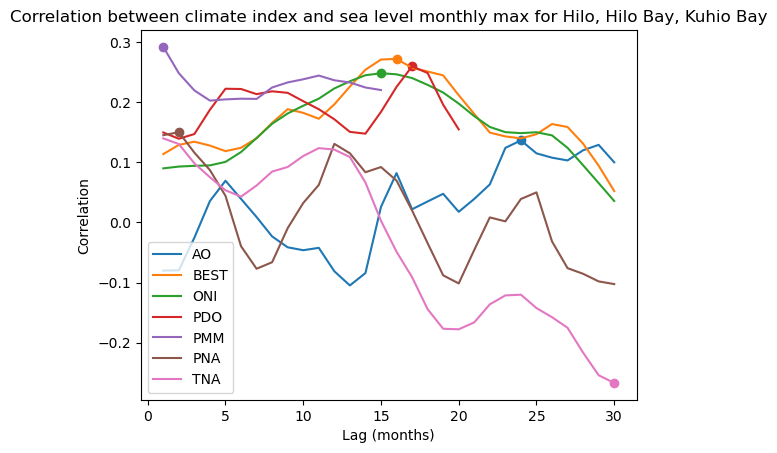

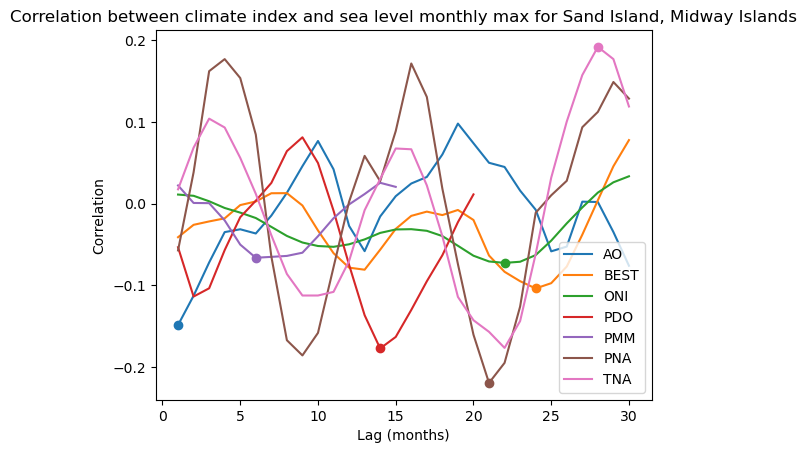

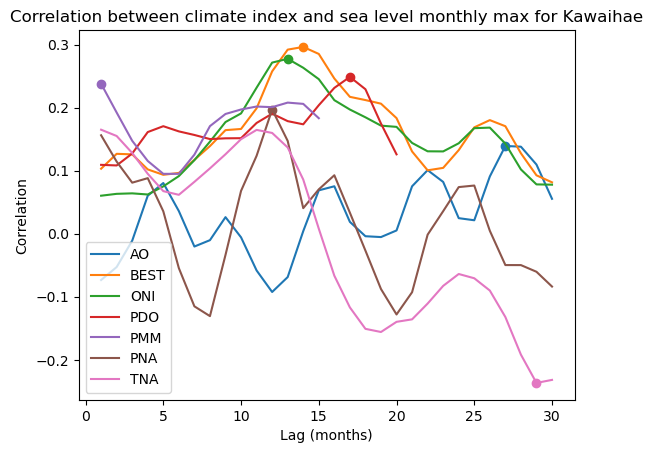

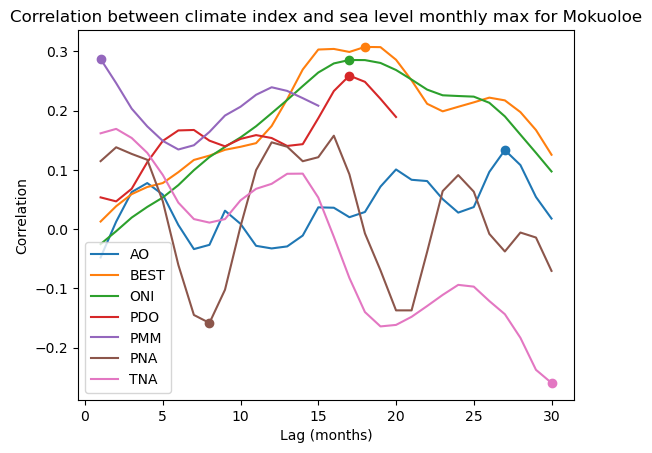

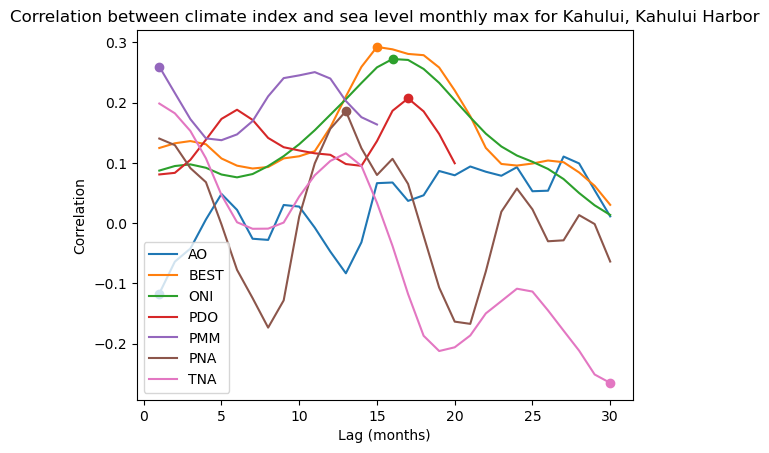

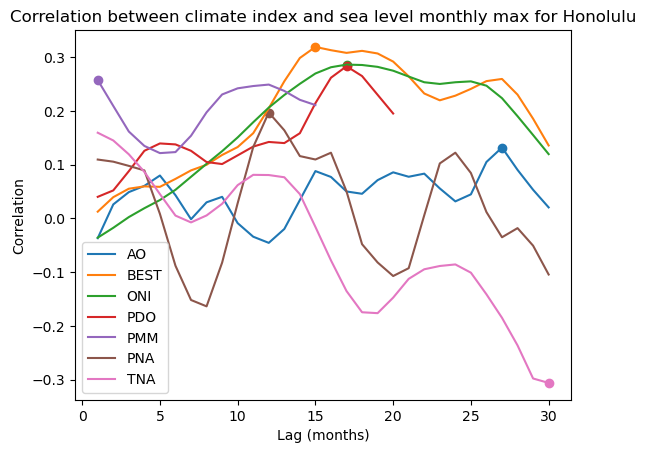

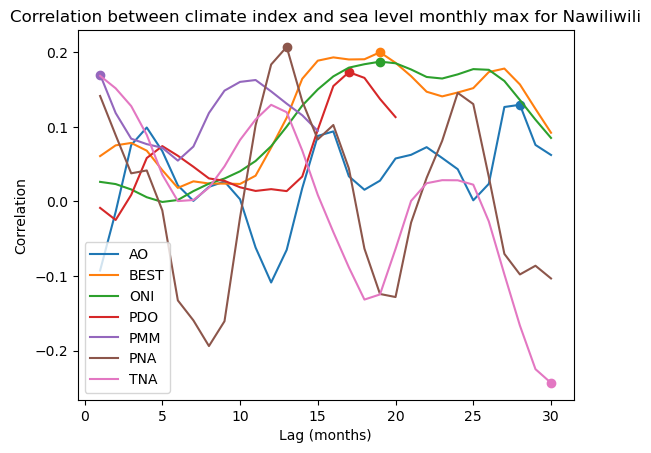

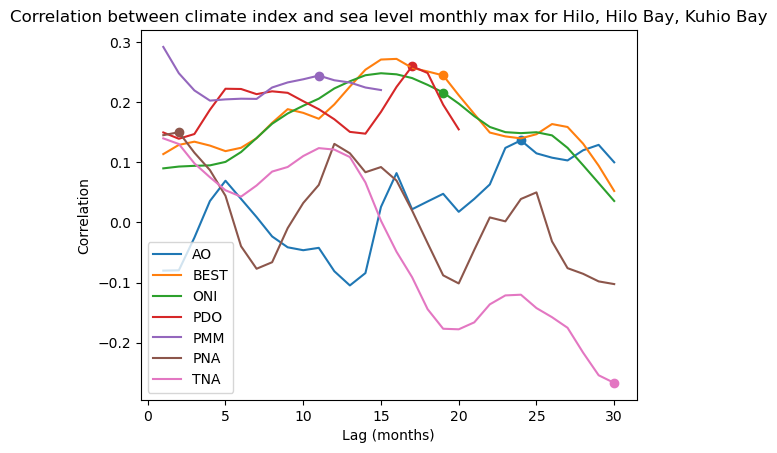

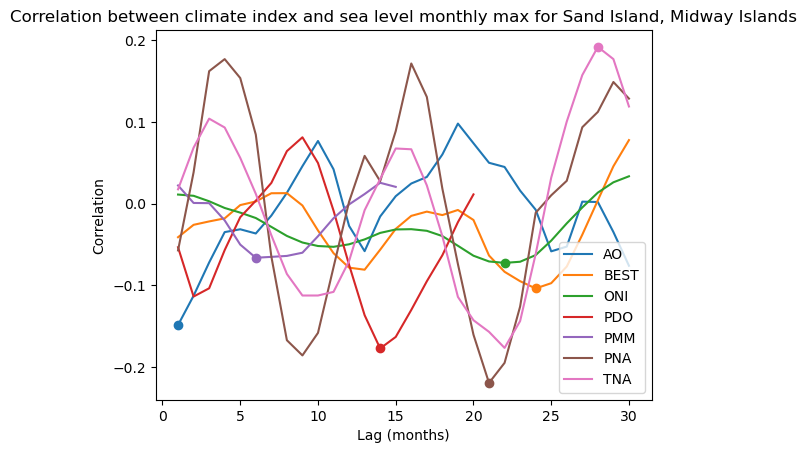

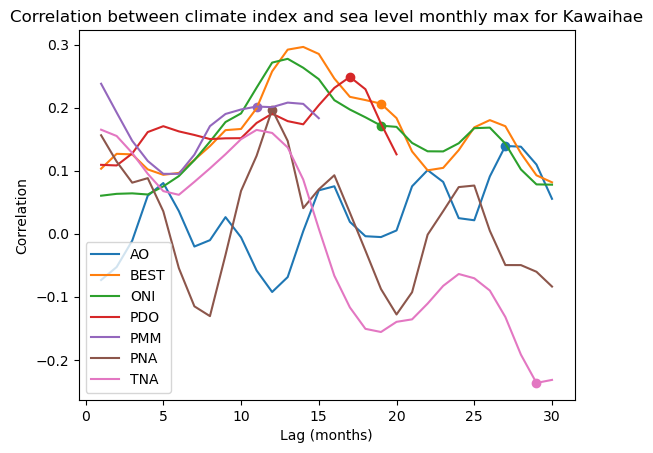

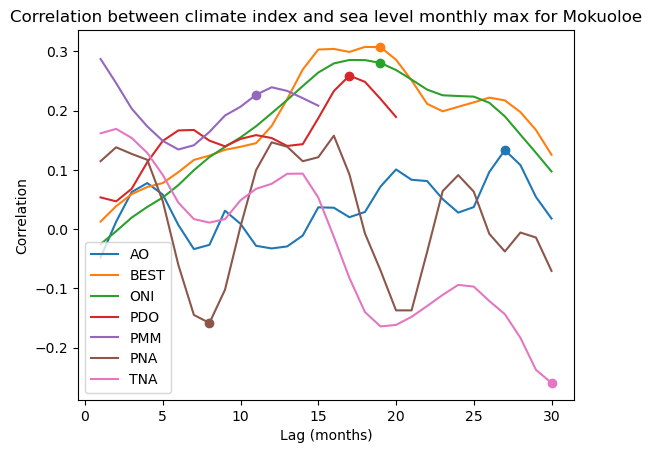

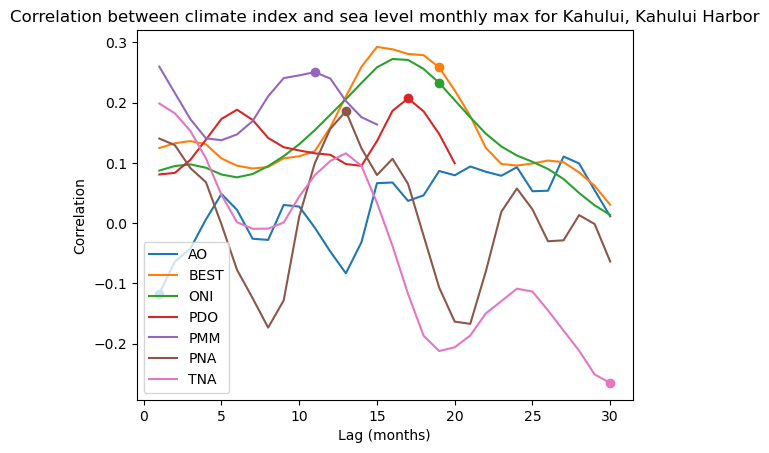

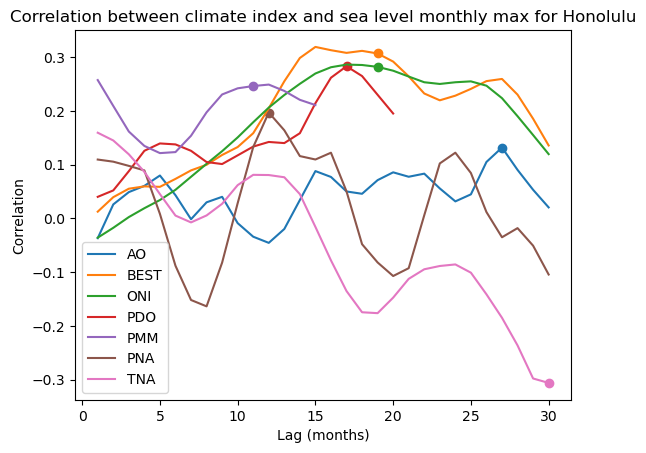

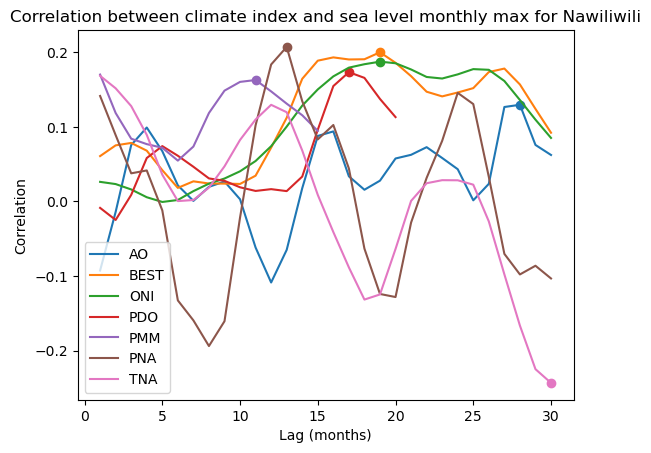

In [11]:
%run ../../functions/get_CI_lags.py


In [12]:
# re import matplotlib (if plotting was disabled in previous cell)
import matplotlib
import matplotlib.pyplot as plt


The following cell preps the model input data by extracting the monthly maximum time series from the given NOAA tide gauge. If a climate covariate is given (CIname), it will create a covariate timeseries from data we've previously downloaded in the [data wrangling](notebooks/SL_Data_Wrangling.ipynb) notebook and processed via the code above.

In [13]:
dirs

{'data_dir': PosixPath('/Users/jfiedler/Projects/SL_Indicators/data'),
 'output_dir': PosixPath('/Users/jfiedler/Projects/SL_Indicators/output/extremes'),
 'input_dir': PosixPath('/Users/jfiedler/Projects/SL_Indicators/model_input'),
 'matrix_dir': PosixPath('/Users/jfiedler/Projects/SL_Indicators/matrix'),
 'model_output_dir': PosixPath('/Users/jfiedler/Projects/SL_Indicators/data/GEV_model_output'),
 'CI_dir': PosixPath('/Users/jfiedler/Projects/SL_Indicators/data/climate_indices'),
 'run_dir': PosixPath('/Users/jfiedler/Projects/SL_Indicators/data/model_run')}

In [14]:
stationID = station_ids[5]
STNDtoMHHW, station_name, year0, mm = models.prep_model_input_data(rsl_hourly,stationID,dirs, CIname,lag=False)

# check for limits file
limitsPath = dirs['run_dir'] / 'limits.txt'
if not limitsPath.exists():
    imports.define_limits(dirs['run_dir'])

print(f"Station name: {station_name}, Station ID: {stationID}, Start year: {year0}")

Data prepared for model input in  /Users/jfiedler/Projects/SL_Indicators/data/model_run
Station name: Honolulu, Station ID: 1612340, Start year: 1993


Let's take a look at what we've got. It should be t (time, in decimal months starting at year0, which we established a few cells ago), the monthly max (in meters, relative to station datum STND), the hour in which that monthly max occured in datetime format, and the climate covariate for that decimal month.

In [15]:
mm

,t,monthly_max,t_monthly_max,CI
0,0.023452,2.009,1993-01-08 14:00:00,-0.679288
1,0.099841,1.966,1993-02-05 13:00:00,-0.005295
2,0.176230,1.902,1993-03-05 12:00:00,0.946665
3,0.268101,1.881,1993-04-08 03:00:00,1.493631
4,0.347336,1.911,1993-05-07 03:00:00,1.495126
...,...,...,...,...
379,31.636840,2.091,2024-08-20 02:00:00,-1.265110
380,31.710496,2.073,2024-09-16 01:00:00,-1.145554
381,31.799522,2.109,2024-10-18 15:00:00,-1.049910
382,31.878757,2.068,2024-11-16 15:00:00,-0.815282


Next we'll make a dictionary called 'modelInfo', which will eventually go into our model output. In this case, we're still exploring seasonality, so we'll skip the covariate. 

In [16]:
 
# make dictionary of STNDtoMHHW, station_name, year0, mm,t,monthly_max,covariate
#make dictionary of stuff that goes into xarray: t,covariate,standard_error,ReturnPeriod,modelName='Model_GEV_S_T_Cv_N.exe',ridString=ridString,savepath=savepath, station_name=station_name,year0=year0)
modelInfo = {'t': mm['t'], 
             'monthlyMax': mm['monthly_max'],
             'covariate': None, 
             'covariateName': CIname, 
             'stationID': stationID, 
             'station_name': station_name, 
             'year0': year0, 
             'ReturnPeriod': return_period,
             'STNDtoMHHW': STNDtoMHHW,
             'datum':'STND'}

## First look: Modeling Seasonality
Here we'll look at seasonality in the location parameter only. Note that you'll need to ensure you have the spotpy package in order to run the SCEUA algorithm (as set up here). Fun fact, this can take a while. Currently, despite nproc=8, it is running in serial. It takes 7 minutes on my (fast) machine, so...maybe it's time for you to go get another cup of coffee or something.

In [17]:
x_s, w_s = models.run_seasonal_model(stationID, dirs,runWithoutModel=runWithoutModel, modelType='GEV_SeasonalMu', nproc=8)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  2500  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...
ComplexEvo loop #2 in progress...
ComplexEvo loop #3 in progress...
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 151.076246
ComplexEvo loop #4 in progress...
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 297.691193
ComplexEvo loop #5 in progress...
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 165.192160
ComplexEvo loop #6 in progress...
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 74.529890
ComplexEvo loop #7 in progress...

## Run the Models

### Extract a timeseries of the time-dependent return values
For each time in a timeseries, we'll evaluate the CDF of the time-dependent GEV at a given return period to get the expected return level. This first function evaluates the extreme value prediction over time for a given return period.

### Calculate Confidence Intervals

The confidence intervals on the following codes are calculated with the derivative of the previous prediction, using finite differencing. We will get be getting the derivative for each parameter in $\theta$, with the goal of solving the total variance.


After we have the derivative function, we can use it to calculate the variance of our estimated return level at each timestep by applying a first-order Taylor expansion, which assumes a locally linear relationship between the function and its parameters. The variance  $\sigma^2$  at each timestep can be approximated as:


$\sigma^2 \approx \mathbf{J}^T \cdot \mathbf{Cov}(w) \cdot \mathbf{J}$


where  $\mathbf{J}$  is the Jacobian (the vector of partial derivatives with respect to the parameters), and  $\mathbf{Cov}(w)$  is the variance-covariance matrix of the parameters. This approach propagates the uncertainties in the parameters into the uncertainty of the return level. The square root of the variance  $\sigma$  gives the standard deviation, which quantifies the uncertainty at each timestep and serves as the basis for calculating confidence intervals.

Note this equation is functionally equivalent to Coles (2001) Theorem 2.4 (the "delta method.")

### Plot monthly extremes and given year return period with the seasonal model


```{margin}
```{caution}
Note that the original code for this plot has the dotted line much lower - the 2 year return, for example, runs through the middle of the data. This corresponds to a 2-month return level, and makes sense if you are looking at each month in isolation (every other year the value is exceeded). This is the case in Méndez et al 2007 (and following papers), and likely comes down to an interpretation of what this line is actually meant to portray. Accounting for the fact that you are sampling monthly data moves the within-a-year return level up to more closely align with the 'stationary' solid line (and the sinusoid formed by the seasonal cycle then varies about the stationary return level). (Julia's opinion here): because this plot is dimensionless (time goes from 0 to 1), we must normalize our data by removing the time component. In this case, the time element is the monthly sampling, so we must scale our probabilities accordingly by (1/12). 
```

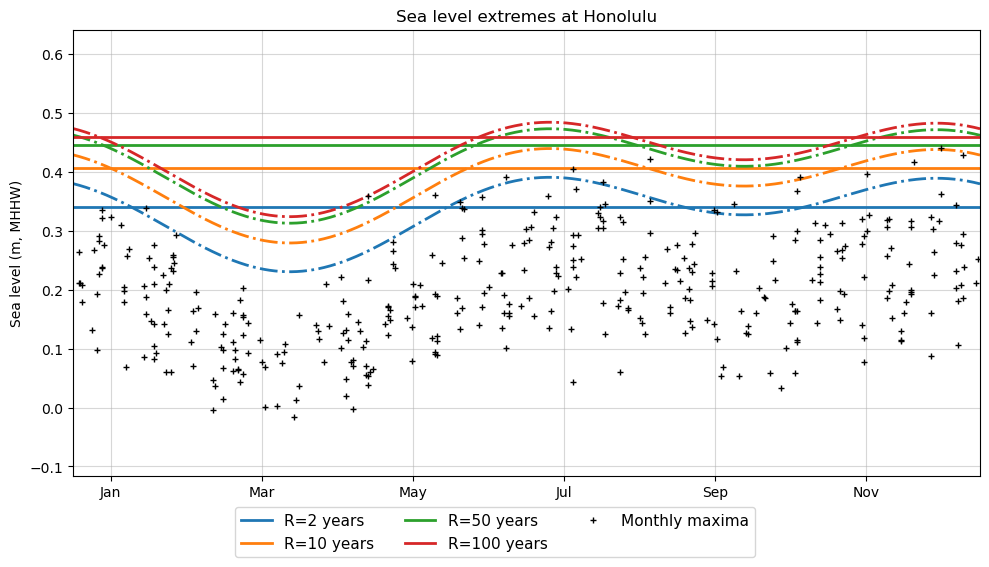

In [18]:
figSeasonal, cmap,seaLevelS = plotting.plotExtremeSeasonality(mm['t'],mm['monthly_max'],x_s,w_s,stationID, STNDtoMHHW, dirs, station_name, ReturnPeriod=return_period,SampleRate=12,saveToFile=saveToFile)

# change the yaxis to
ax = figSeasonal.axes[0]
ax.set_ylim(mm['monthly_max'].min()-STNDtoMHHW-0.1, mm['monthly_max'].max()-STNDtoMHHW+0.2)

# save the figure
savename = 'SeasonalExtremeVariations_'+ stationID +'.png'
savedir = os.path.join(output_dir, savename)
plt.savefig(savedir, dpi=250, bbox_inches='tight')

glue("seasonal_extreme_variations", figSeasonal, display=False)

```{glue:figure} seasonal_extreme_variations
:name: "seasonal_extreme_variations"
A climatology of extreme sea levels at the {glue:text}`station_name` tide gauge. Monthly maxima (+), determined from hourly sea level data, are shown from 1993-2024. The solid line corresponds to projected sea level return levels at 2,10,50 and 100 years, using this 30-year chunk of data. This line uses a nonstationary GEV to take the seasonal variations of sea level into account. The 2, 10, 50 and 100-year return levels are shown to vary throughout the year (dashed line), with the lowest extremes occuring in March, and highest extremes peaking in July. No long-term trend is used in this model, and the scale and location parameters are held constant.
```

### Check if we should include a long-term trend (mean sea level rise) in our location parameter
I mean, it's probably statistically significant, but hey, we should test just in case. First, we'll make a function to save our modeled return levels.

In [19]:
x_T, w_T, SignifTrend = models.run_long_term_trend_model(x_s, w_s, stationID, dirs, modelInfo, runWithoutModel=runWithoutModel, modelType='GEV_S_T_Cv', nproc=numProcesses)


Assessing standard error...
Statistical Significance of Linear Trend: 100.00%
Estimated Trend on monthly Maxima values is: 3.25 +/- 0.37 mm/year
Time-dependent return values calculated
Model saved to netcdf file at:  /Users/jfiedler/Projects/SL_Indicators/data/GEV_model_output/1612340/RL_muT.nc


### Check the nodal and perigean cycles in Location parameter
We will only include the nodal and perigean cycles in our final model if adding it significantly improves our model thus far. We will add it to the long-term trend model if the long-term trend is significant.

In [ ]:
x_N, w_N, wcomp, SignifN = models.run_nodal_model(x_T, w_T, x_s, w_s, SignifTrend, stationID, dirs, modelInfo, runWithoutModel=True, modelType='GEV_S_T_Cv_Nodal', nproc=numProcesses)
x_N

The trend is significant! 
Include long-term trend and nodal cycle in final model.
Running Nodal cycle model...


### Check the covariate in the location parameter.
Let's check if the covariate inclusion in the location parameter is statistically significant.

In [ ]:
x_cvte1, w_cvte1, wcomp, SignifCvte1 = models.run_covariate_in_location_model(x_N, w_N, wcomp, stationID, SignifTrend, dirs, modelInfo, runWithoutModel=runWithoutModel, modelType='GEV_S_T_Cv_Nodal',saveModel=True, nproc=numProcesses)  
x_cvte1

Statistical Significance of PMM in location param: 100.00%
Model already saved to netcdf file.


array([1, 1, 0, 1, 1, 0, 1])

### Check the covariate in scale parameter
Let's check if the covariate inclusion in the scale parameter is statistically significant.

In [ ]:
x_cvte2, w_cvte2, wcomp, SignifCvte2 = models.run_covariate_in_scale_model(x_cvte1, w_cvte1, wcomp, stationID,SignifCvte1, dirs, modelInfo, runWithoutModel=True, modelType='GEV_S_T_Cv_Nodal',saveModel=True, nproc=numProcesses)


Statistical Significance of PMM in scale param.: 99.96%
Model already saved to netcdf file.


Get a list of the parameter names that correspond to the 'x_cvte2' variable.

In [ ]:
param_names = ['Annual seasonal cycle',
    'Semiannual seasonal cycle',
    'Triannual seasonal cycle',
    'Long-term Trend in Location',
    'Covariate in Location',
    'Covariate in Scale',
    'Nodal Cycle']

# Write out the parameter names, where if x[i] = 1, the parameter is included, otherwise it is removed from the list
parameters_included = [param for i, param in zip(x_cvte2, param_names) if i == 1]


# Format the parameter names for display, where each parameter is separated by a comma and the last parameter is preceded by 'and'
parameters_included = ', '.join(parameters_included[:-1]) + ', and ' + parameters_included[-1]
glue("parameters_included", parameters_included)


'Annual seasonal cycle, Semiannual seasonal cycle, Long-term Trend in Location, Covariate in Location, Covariate in Scale, and Nodal Cycle'

## Plot the timeseries

Finally we'll calculate the time dependent return value, with confidence intervals from above, using only the nodal + long-term trend + seasonality model. The plotTimeDependentReturnValue code evaluates the likelihood function using the modeled parameters for a given set of years and return periods (in years). It will also return the 95% confidence intervals, with the assumption of Guassian distribution ($\pm 1.96 \sigma$).

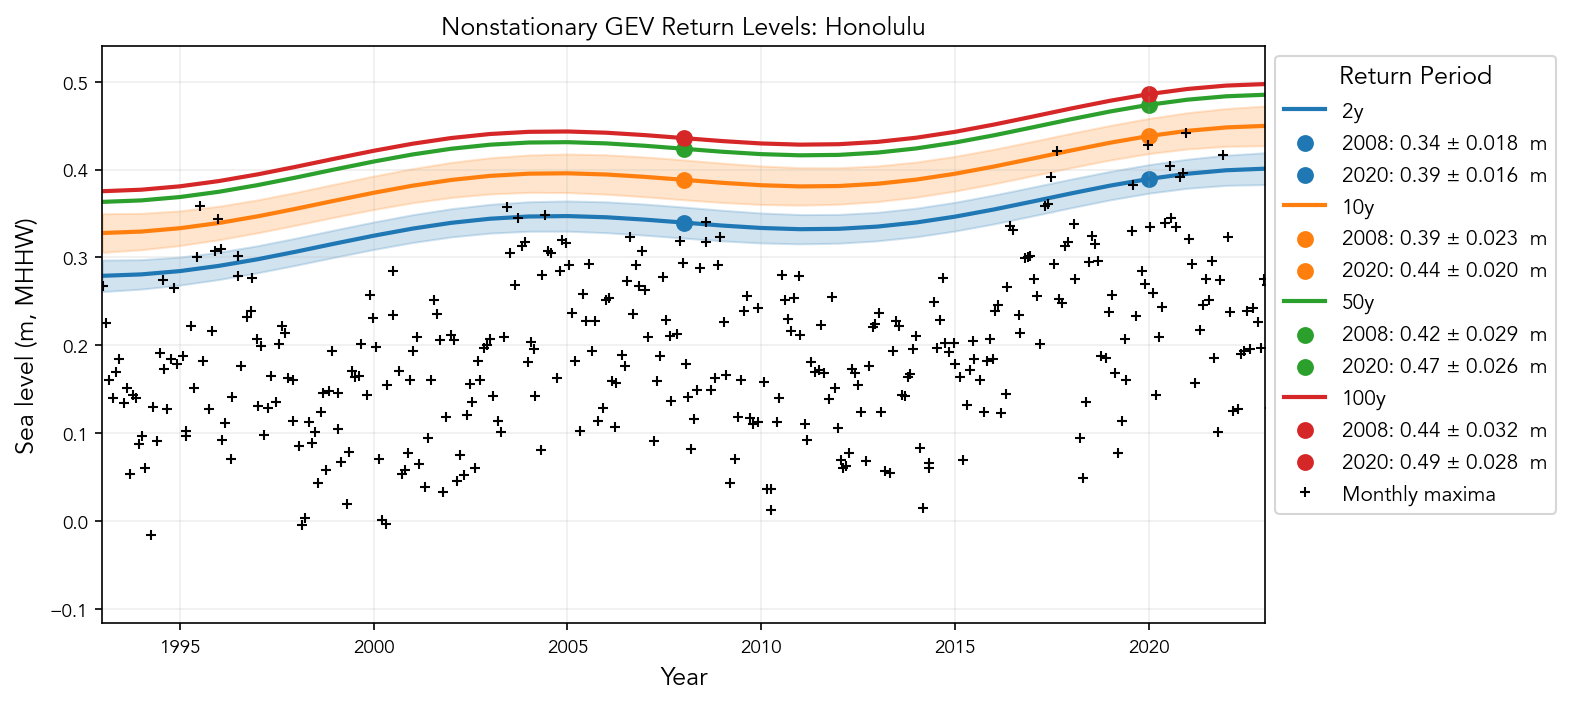

In [ ]:
fig = plotting.plotTimeDependentReturnValue(stationID, 
                                            STNDtoMHHW, 
                                            dirs['model_output_dir'], 
                                            station_name, 
                                            output_dir, 
                                            mm, 
                                            year0plot, 
                                            saveToFile=True,
                                            specModel='RL_muN.nc')

# set y-limits on the axes
ax = fig.axes[0]
ax.set_ylim(mm['monthly_max'].min()-STNDtoMHHW-0.1, mm['monthly_max'].max()-STNDtoMHHW+0.1)


# save the figure

savename = 'TimeDependentReturnValue_'+ stationID +'.png'
savedir = os.path.join(output_dir, savename)
plt.savefig(savedir, dpi=300, bbox_inches='tight')

# glue the figure
glue("TimeDependentReturnValue", fig, display=False)


```{glue:figure} TimeDependentReturnValue
:name: "TimeDependentReturnValue"
Time series of the nonstationary GEV-based extreme water level return values for {glue:text}`station_name`. The monthly maxima (+) are displayed spanning data from {glue:text}`year0` to 2023. The return levels (at 2, 10, 50, and 100 year levels) are shown in solid lines. The 95% Confidence Interval (shaded area) also varies in time, and is shown only for the 2 and 10 year return levels. Years 2008 and 2020 are highlighted on these curves to show the differences in values when taking seasonality, a long-term trend, and the 18.6 nodal-cycle into account. This particular best-fit model for {glue:text}`station_name` includes the {glue:text}`parameters_included`. Note we have not included the perigean cycle in this model. That's in another notebook!!
```


We can also make it interactive.

In [ ]:
#The mean of the location parameter should be the mean of the monthly maxima
meanmaxSL = w_cvte2[1]-STNDtoMHHW
#The standard deviation should be the standard deviation of the monthly maxima  
rangemaxSL = w_cvte2[2]
fig = plotting.plotTimeDependentReturnValue_plotly(stationID, 
                                                   STNDtoMHHW, 
                                                   dirs['model_output_dir'], 
                                                   station_name, 
                                                   mm, 
                                                   year0plot, 
                                                   meanmaxSL, 
                                                   rangemaxSL,
                                                   specModel='RL_muN.nc')

## Create a combined dataset for further plotting and analysis

You'll want to go back and run the above codes for every station to make the maps.

In [ ]:
# One dataset to rule them all

# Find all RL_muN.nc files
file_pattern = str(dirs['model_output_dir'] / '**/RL_muN.nc')
file_paths = glob.glob(file_pattern, recursive=True)

# Initialize an empty list to hold each dataset
datasets = []

for file_path in file_paths:
    ds = xr.open_dataset(file_path)
    
    # Extract important attributes
    station_id = int(ds.attrs.get('station_id'))    
    station_name = ds.attrs.get('station_name')
    x = ds.attrs.get('x')  # Assuming x is stored as an attribute and has varying lengths
    
    # Ensure 'year' and 'return_level' are coordinates and are preserved
    year = ds['year'] if 'year' in ds else ds.coords.get('year')
    return_level = ds['return_level'] if 'return_level' in ds else ds.coords.get('return_level')
    
    # Expand the dataset with the 'station' dimension (coordinate)
    ds = ds.expand_dims({'station_id': [station_id]})
    
    # Store x as a variable with its own dimension (e.g., 'x_dim')
    ds['x'] = xr.DataArray(x, dims=['x_dim'])
    
    # Keep station_name as an attribute of the dataset
    ds.attrs['station_name'] = station_name
    
    # Add the dataset to the list
    datasets.append(ds)

# Combine all datasets along the 'station' dimension
try:
    combined_ds = xr.concat(datasets, dim='station_id', combine_attrs='override')
    print("Combined dataset created successfully.")
except Exception as e:
    print(f"An error occurred during dataset concatenation: {e}")

# remove attributes that are not needed
attributes_to_remove = ['station_name', 'model_parameters', 'model_standard_error', 'model', 'x', 'record_id']
for attr in attributes_to_remove:
    combined_ds.attrs.pop(attr, None)

Combined dataset created successfully.


/var/folders/9w/vpws17h965v7n60fmhp97k5r0000gq/T/ipykernel_44024/2564015510.py:36: FutureWarning:

In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.



In [ ]:
combined_ds

<xarray.Dataset> Size: 22kB
Dimensions:       (station_id: 7, ReturnPeriod: 4, Year: 32, x_dim: 7)
Coordinates:
  * station_id    (station_id) int64 56B 1612340 1617433 ... 1617760 1619910
  * Year          (Year) float64 256B 1.993e+03 1.994e+03 ... 2.024e+03
  * ReturnPeriod  (ReturnPeriod) int64 32B 2 10 50 100
Dimensions without coordinates: x_dim
Data variables:
    ReturnLevel   (station_id, ReturnPeriod, Year) float64 7kB 2.02 ... 1.987
    RL_low        (station_id, ReturnPeriod, Year) float64 7kB 2.002 ... 1.91
    RL_high       (station_id, ReturnPeriod, Year) float64 7kB 2.038 ... 2.065
    x             (station_id, x_dim) int64 392B 1 1 0 1 0 0 1 ... 1 1 0 1 0 0 0
Attributes:
    description:     Time-dependent return values for the GEV model with seas...
    datum:           STND
    station_id:      1612340
    units:           m
    covariateName:   PMM
    standard_error:  [0.00724678 0.00260871 0.03134728 0.00476136 0.00488768 ...
    covariate:       PMM

In [ ]:
# add lat, lon, and station_name to the dataset from rsl_hourly
rids = [str(rid) for rid in combined_ds['station_id'].values]
lats = []
lons = []
MHHW = []
for rid in rids:
    lat = rsl_hourly.sel(station_id=rid)['lat'].values
    lon = rsl_hourly.sel(station_id=rid)['lon'].values
    mhhw = rsl_hourly.sel(station_id=rid)['MHHW'].values
    lats.append(lat)
    lons.append(lon)
    MHHW.append(mhhw)

combined_ds['lat'] = xr.DataArray(lats, dims='station_id')
combined_ds['lon'] = xr.DataArray(lons, dims='station_id')
combined_ds['MHHW'] = xr.DataArray(MHHW, dims='station_id')

# add station_name
station_names = rsl_hourly.sel(station_id=rids)['station_name'].values
combined_ds['station_name'] = xr.DataArray(station_names, dims='station_id')

# save the combined dataset to a netcdf file
# combined_ds.to_netcdf(output_dir / 'combined_return_levels.nc')
combined_ds


<xarray.Dataset> Size: 23kB
Dimensions:       (station_id: 7, ReturnPeriod: 4, Year: 32, x_dim: 7)
Coordinates:
  * station_id    (station_id) int64 56B 1612340 1617433 ... 1617760 1619910
  * Year          (Year) float64 256B 1.993e+03 1.994e+03 ... 2.024e+03
  * ReturnPeriod  (ReturnPeriod) int64 32B 2 10 50 100
Dimensions without coordinates: x_dim
Data variables:
    ReturnLevel   (station_id, ReturnPeriod, Year) float64 7kB 2.02 ... 1.987
    RL_low        (station_id, ReturnPeriod, Year) float64 7kB 2.002 ... 1.91
    RL_high       (station_id, ReturnPeriod, Year) float64 7kB 2.038 ... 2.065
    x             (station_id, x_dim) int64 392B 1 1 0 1 0 0 1 ... 1 1 0 1 0 0 0
    lat           (station_id) float64 56B 21.3 20.04 20.89 ... 19.73 28.21
    lon           (station_id) float64 56B 202.1 204.2 203.5 ... 204.9 182.6
    MHHW          (station_id) float64 56B 1.741 1.444 1.422 ... 1.927 1.206
    station_name  (station_id) <U27 756B 'Honolulu' ... 'Sand Island, Midway ...
Attributes:
    description:     Time-dependent return values for the GEV model with seas...
    datum:           STND
    station_id:      1612340
    units:           m
    covariateName:   PMM
    standard_error:  [0.00724678 0.00260871 0.03134728 0.00476136 0.00488768 ...
    covariate:       PMM

## Create a Map

In [ ]:
# Suppress Shapely warnings that occur with cartopy mapping
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, 
                      message="invalid value encountered in create_collection")

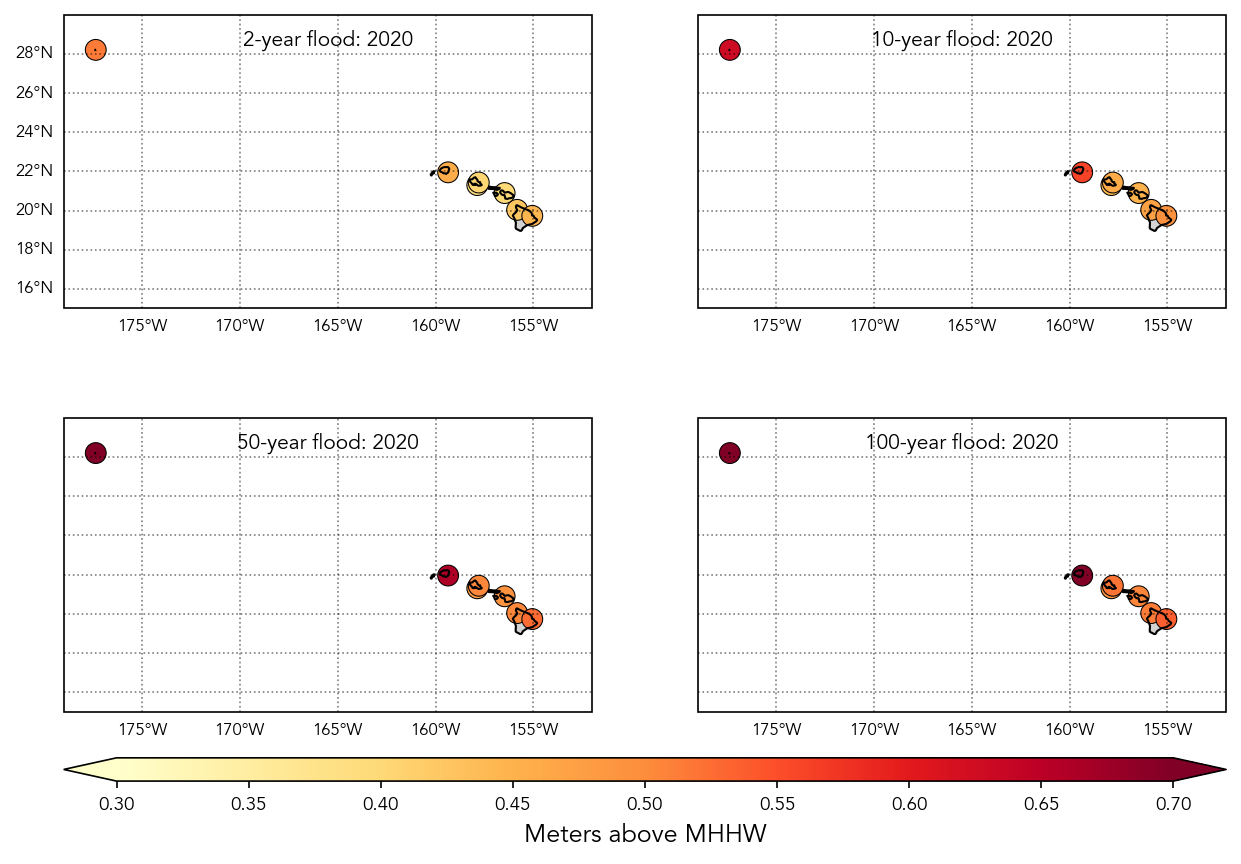

In [ ]:
crs = ccrs.PlateCarree()
fig, axs = plt.subplots(2,2,figsize=(10, 8), subplot_kw={'projection': crs})
# make ax,fig
# open the cmems data

xlims = [-179, -152]
ylims = [15, 30]

scatters = []

# plt.colorbar(maxplt,ax=axs[0],label='Sea Level (m)', location='bottom')           

for i, ax in enumerate(axs.flat):

    scatter = ax.scatter(combined_ds['lon'], combined_ds['lat'], transform=crs, s=100, 
               c=combined_ds['ReturnLevel'].sel(Year=2020)[:,i]-combined_ds['MHHW'], cmap='YlOrRd',
               linewidth=0.5, edgecolor='black')
    scatters.append(scatter)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    # set extent
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], crs=crs)

    #add grid
    gl = ax.gridlines(draw_labels=False, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    if i>=0:
        gl.bottom_labels = True

    if i==0:
        gl.left_labels = True

    #make all labels tiny
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # add text to top left of plot
    ax.text(0.5, 0.95, f'{return_period[i]}-year flood: 2020', color='black', fontsize=10, weight='bold',
            transform=ax.transAxes, ha='center', va='top', zorder=10)

# add colorbar to the bottom of the plot which follows vmin, vmax and cmap of the scatter plot
# colorbar should be 
cbar = plt.colorbar(axs[1, 1].collections[0], ax=axs, orientation='horizontal', pad=0.05, aspect=50,extend='both')
cbar.set_label('Meters above MHHW')

# set the limits of the colorbar
for scatter in scatters:
    scatter.set_clim(vmin=0.3, vmax=0.7)

# save the figure
plt.savefig(output_dir / 'TimeDependentReturnValueMap.png', dpi=300, bbox_inches='tight')

# Display the figure - just return it instead of using plt.show()
fig

glue("TimeDependentReturnValueMap",fig,display=False)

```{glue:figure} TimeDependentReturnValueMap
:name: "TimeDependentReturnValueMap"
Map of the nonstationary GEV-based extreme water level return values for Hawaiian Island region stations. Year 2020 is shown here. Each nonstationary model includes some combination of seasonality, a long-term trend, and the 18.6 nodal-cycle, provided each parameter improves the significance of the GEV fit. No covariates are used for these particular best-fit models.
```

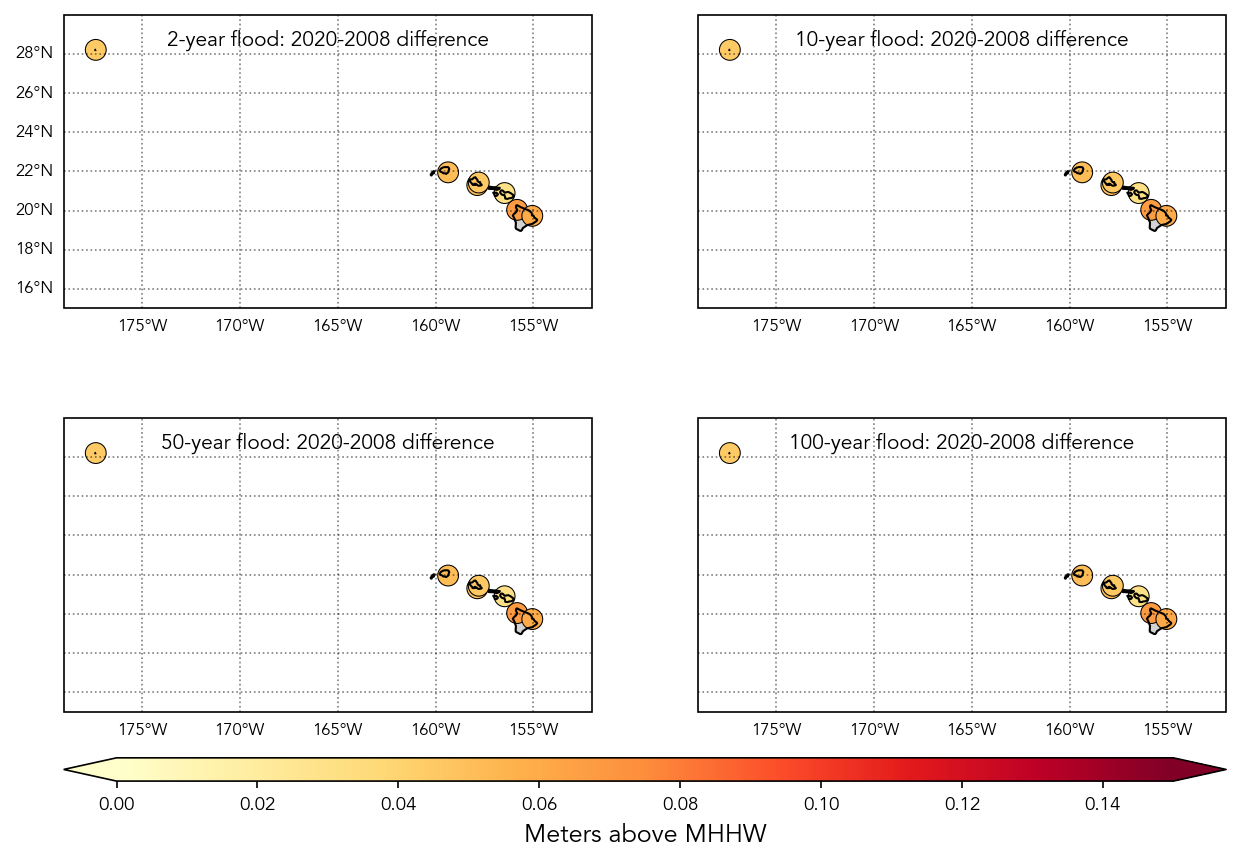

In [ ]:
crs = ccrs.PlateCarree()
fig, axs = plt.subplots(2,2,figsize=(10, 8), subplot_kw={'projection': crs})
# make ax,fig
# open the cmems data

xlims = [-179, -152]
ylims = [15, 30]

scatters = []

# plt.colorbar(maxplt,ax=axs[0],label='Sea Level (m)', location='bottom')           

for i, ax in enumerate(axs.flat):

    scatter = ax.scatter(combined_ds['lon'], combined_ds['lat'], transform=crs, s=100, 
               c=combined_ds['ReturnLevel'].sel(Year=2020)[:,i]-combined_ds['ReturnLevel'].sel(Year=2008)[:,i], cmap='YlOrRd',
               linewidth=0.5, edgecolor='black')
    scatters.append(scatter)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    # set extent
    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], crs=crs)

    #add grid
    gl = ax.gridlines(draw_labels=False, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    if i>=0:
        gl.bottom_labels = True

    if i==0:
        gl.left_labels = True

    #make all labels tiny
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}

    # add text to top left of plot
    ax.text(0.5, 0.95, f'{return_period[i]}-year flood: 2020-2008 difference', color='black', fontsize=10, weight='bold',
            transform=ax.transAxes, ha='center', va='top', zorder=10)

# add colorbar to the bottom of the plot which follows vmin, vmax and cmap of the scatter plot
# colorbar should be 
cbar = plt.colorbar(axs[1, 1].collections[0], ax=axs, orientation='horizontal', pad=0.05, aspect=50,extend='both')
cbar.set_label('Meters above MHHW')

# set the limits of the colorbar
for scatter in scatters:
    scatter.set_clim(vmin=0, vmax=0.15)

# save the figure
plt.savefig(output_dir / 'TimeDependentReturnValueMap2008.png', dpi=300, bbox_inches='tight')

# Display the figure - remove plt.show() and just return the figure
fig

glue("TimeDependentReturnValueMap2008",fig,display=False)

---

## Citations

```{bibliography}
:style: plain
:filter: docname in docnames
```